In [104]:
pip install -U nltk

Note: you may need to restart the kernel to use updated packages.


In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Include for clearing session (optional):
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re,nltk,json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
# class color: # Text style
#    PURPLE = '\033[95m'
#    CYAN = '\033[96m'
#    DARKCYAN = '\033[36m'
#    BLUE = '\033[94m'
#    GREEN = '\033[92m'
#    YELLOW = '\033[93m'
#    RED = '\033[91m'
#    BOLD = '\033[1m'
#    UNDERLINE = '\033[4m'
#    END = '\033[0m'

Total number of Speech: 1529


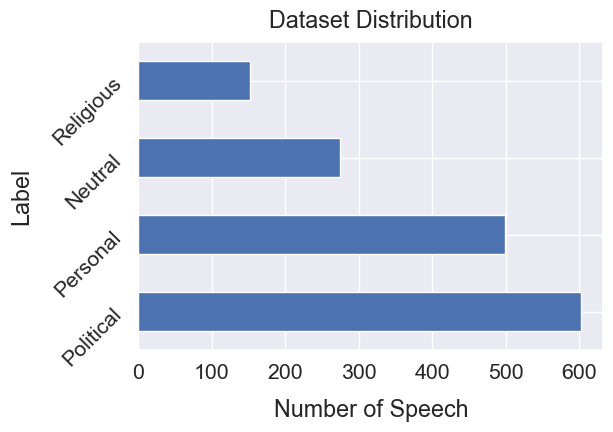

In [106]:
data = pd.read_csv('onlytext.csv',encoding='utf-8')
print(f'Total number of Speech: {len(data)}')
sns.set(font_scale=1.4)
data['Label'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of Speech", labelpad=12)
plt.ylabel("Label", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [107]:
data.columns

Index(['Speech', 'Label'], dtype='object')

In [108]:
# Cleaning Data [Remove unncessary symbols]
def cleaning_data(row):
      speech = re.sub('[^\u0980-\u09FF]',' ',str(row)) #removing unnecessary punctuation
      return speech
# Apply the function into the dataframe
data['cleaned'] = data['Speech'].apply(cleaning_data)  

# print some cleaned reviews from the dataset
sample_data = [75,194,6,201]
for i in sample_data:
  print('Original: ',data.Speech[i],'\nCleaned:',
           data.cleaned[i],'\n','Label:-- ',data.Label[i],'\n')

Original:  SK. Inventals Limited এবং NTV যৌথভাবে আলজিমেট দিবা শিরোনামে beauty and talent প্রতিযোগিতা শুরু করতে যাচ্ছে. এ উপলক্ষে এক সংবাদ সম্মেলনে জানানো হয় এর registration শুরু হবে ডিসেম্বরের মাঝামাঝিতে. আঠারো থেকে আঠাশ বছর বয়সী বাংলাদেশে মেয়েরা অংশ নিতে পারবে এই প্রতিযোগিতায় তবে আগ্রহী প্রবাসী বাংলাদেশী প্রতিযোগীদেরও এতে আমন্ত্রণ জানানো হয়েছে. তা নিয়ে আমাদেরকে চলতে হয় এবং সেটাতে সন্তুষ্ট থাকতে হয়. রাজধানীর সাতাশ নম্বর রোডে একই সাথে ম্যানসপার্লার স্পোর্টস এবং খাবারের বিশাল আয়োজন নিয়ে যাত্রা শুরু করলো 
Cleaned:                       এবং     যৌথভাবে আলজিমেট দিবা শিরোনামে                   প্রতিযোগিতা শুরু করতে যাচ্ছে  এ উপলক্ষে এক সংবাদ সম্মেলনে জানানো হয় এর              শুরু হবে ডিসেম্বরের মাঝামাঝিতে  আঠারো থেকে আঠাশ বছর বয়সী বাংলাদেশে মেয়েরা অংশ নিতে পারবে এই প্রতিযোগিতায় তবে আগ্রহী প্রবাসী বাংলাদেশী প্রতিযোগীদেরও এতে আমন্ত্রণ জানানো হয়েছে  তা নিয়ে আমাদেরকে চলতে হয় এবং সেটাতে সন্তুষ্ট থাকতে হয়  রাজধানীর সাতাশ নম্বর রোডে একই সাথে ম্যানসপার্লার স্পোর্টস এবং খাবারের বিশ

In [109]:
# Length of each Speech
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))
# Remove the Speech with least words
dataset = data.loc[data.length>2]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small speeches".format(len(data)-len(dataset)),
      "\nTotal Speech:",len(dataset))

After Cleaning: 
Removed 6 Small speeches 
Total Speech: 1523


In [110]:
def data_summary(dataset):
    
    """
    This function will print the summary of the Speech and words distribution in the dataset. 
    
    Args:
        dataset: list of cleaned sentences   
        
    Returns:
        Number of documnets per class: int 
        Number of words per class: int
        Number of unique words per class: int
    """
    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.Label.value_counts().to_dict().items()]
  # find word list
    for label in class_label: 
        word_list = [word.strip().lower() for t in list(dataset[dataset.Label==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list  
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(dataset[dataset.Label==label].cleaned)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class 
        u_words.append(len(np.unique(word_list)))
       
        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.Label==label].cleaned))))  
        print("Number of Words:{}".format(len(word_list))) 
        print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))           
   
    return documents,words,u_words,class_label

#call the fucntion
documents,words,u_words,class_names = data_summary(dataset)  


Class Name :  Political
Number of Documents:601
Number of Words:16632
Number of Unique Words:5196
Most Frequent Words:

না	268
করে	166
ভারতের	156
আর	155
ভারত	146
এই	125
কি	105
আমি	103
শেখ	89
তো	86

Class Name :  Personal
Number of Documents:495
Number of Words:30923
Number of Unique Words:6540
Most Frequent Words:

না	811
আমি	553
আমার	489
কি	428
করে	365
তোর	359
এই	354
তো	327
তুই	288
আর	283

Class Name :  Neutral
Number of Documents:275
Number of Words:33848
Number of Unique Words:8047
Most Frequent Words:

এই	356
করে	338
থেকে	309
না	309
যে	268
এবং	240
আমরা	211
হয়	206
ও	197
এর	189

Class Name :  Religious
Number of Documents:152
Number of Words:2908
Number of Unique Words:1416
Most Frequent Words:

মালাউন	51
না	47
আর	33
মালাউনের	31
করে	28
তুই	27
কি	23
ও	22
কে	19
এই	19
Total Number of Unique Words:15720


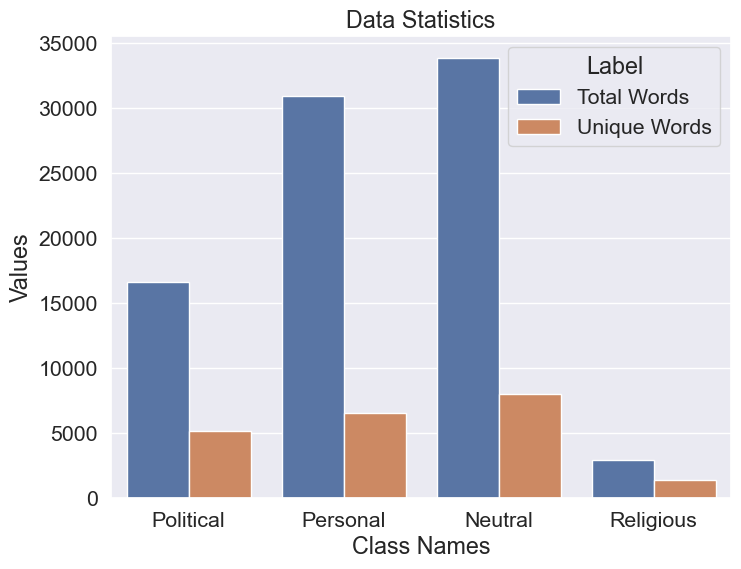

In [111]:
data_matrix = pd.DataFrame({
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Label", value_name="Values")
plt.figure(figsize=(8, 6))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Label')
ax.set_xlabel('Class Names') 
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=0);

In [112]:
def label_encoding(category,bool):
    """
    This function will return the encoded labels in array format. 
    
    Args:
        category: series of class names(str)
        bool: boolean (True or False)
        
    Returns:
        labels: numpy array 
    """
    le = LabelEncoder()
    le.fit(category)
    encoded_labels = le.transform(category)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t Label Encoding ","\nClass Names:",le.classes_)
        for i in sample_data:
            print(category[i],' ', encoded_labels[i],'\n')

    return labels


def dataset_split(Speech,Label):
    """
    This function will return the splitted (90%-10%-10%) feature vector . 
    
    Args:
        headlines: sequenced headlines 
        category: encoded lables (array) 
        
    Returns:
        X_train: training data 
        X_valid: validation data
        X_test : testing feature vector 
        y_train: training encoded labels (array) 
        y_valid: training encoded labels (array) 
        y_test : testing encoded labels (array) 
    """

    X,X_test,y,y_test = train_test_split(Speech,Label,train_size = 0.75,
                                                  test_size = 0.25,random_state =0)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(Speech),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))
  
    return X_train,X_valid,X_test,y_train,y_valid,y_test

In [113]:
labels = label_encoding(dataset.Label,True)


			 Label Encoding  
Class Names: ['Neutral' 'Personal' 'Political' 'Religious']
Neutral   0 

Political   2 

Religious   3 

Personal   1 



In [114]:
X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(dataset.Speech,labels)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 1523 
	Training		 913 
	Test			 381 
	Validation		 229


In [115]:
vocab_size = 15720
embedding_dim = 64
max_length = 2000
trunc_type='post'
padding_type='post'
oov_tok = ""

def padded_Speech(original,encoded,padded):
  '''
  print the samples padded headlines
  '''
  print("\n\t\t\t====== Encoded Sequences ======","\n")  
  print(original,"\n",encoded) 
  print("\n\t\t\t====== Paded Sequences ======\n",original,"\n",padded)  

In [116]:
# Train Data Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)


In [117]:
(word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
def tokenizer_info(mylist,bool):
  ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
  for w,c in ordered[:10]:
    print(w,"\t",c)
  
print("\t\t\t====== Tokenizer Info ======")   
print("Words --> Counts:")
tokenizer_info(word_counts,bool =True )
print("\nWords --> Documents:")
tokenizer_info(word_docs,bool =True )
print("\nWords --> Index:")
tokenizer_info(word_index,bool =True )    
print("\nTotal Documents -->",document_count)
print(f"Found {len(word_index)} unique tokens")

			====== Tokenizer Info ======
Words --> Counts:
না 	 833
করে 	 522
এই 	 492
আমি 	 489
আমার 	 374
কি 	 362
আর 	 358
থেকে 	 327
তো 	 326
যে 	 323

Words --> Documents:
না 	 302
করে 	 243
এই 	 233
আর 	 204
থেকে 	 185
কি 	 160
তো 	 159
আমি 	 153
যে 	 151
আছে 	 145

Words --> Index:
ফেলব 	 11871
ম্যাপ 	 11870
মোধ্য 	 11869
৫ 	 11868
জমের 	 11867
বিনিময়ে 	 11866
ইন্দন 	 11865
দিগন্ত 	 11864
নয়া 	 11863
সামলা 	 11862

Total Documents --> 913
Found 11871 unique tokens


In [118]:
padded_Speech(X_train[10],train_sequences[10],train_padded[10]) 


			====== Encoded Sequences ====== 

হ্যালো বন্ধুরা তোমরা সবাই কেমন আছো? আশা করি সবাই ভালো আছো. আমরা অনেকেই জানি না বয়সের ছোট ছেলেরা মিলন করলে মেয়েরা মজা পায় কিনা. আজকে তোমাদের সাথে এই বিষয় নিয়ে আলোচনা করব. তাই ভিডিওটি না দিলে পুরো ভিডিওটি দেখার অনুরোধ রইল. আমরা যখন কোনো ছেলে অথবা মেয়ে একজন আরেকজনের প্রেমে পড়ি তখন কেউ তার বংশধর ধর্ম বয়স দেখে প্রেম করিনা. প্রেমে পড়ার সময় আমরা অন্ধ হয়ে যাই. তাই আমার সঙ্গী আমার বয়সে বড় হল না ছোট হল আমাদের কাছে এটা কোন ব্যাপার মনে হয় না. প্রথমে মেয়েদের কথাই বলি. মেয়েদের ষোলো থেকে ছাব্বিশ বছর এই দশ বছর তাদের যৌন চাহিদা চরম পর্যায় থাকে. এই দশ বছর তাদের মাথা নষ্ট থাকে. এখন কথা হল ছেলেদের যৌন চাহিদা কত বছর পর্যন্ত থাকে? ছেলেদের যৌন চাহিদা মরণের আগ পর্যন্ত থাকে. কিন্তু তারা তিরিশ থেকে পঁয়ত্রিশ বছর পর্যন্ত তার সঙ্গীকে সন্তুষ্ট রাখতে পারে. সে হোক কচি বা মধ্য বয়সী. তাই ছোট ছেলেরা যখন মেয়েদের সাথে মিলন করে, আর তার সঙ্গীর বয়স যদি চব্বিশের নিচে বা উপরেও হয়, তার কোন সমস্যা নেই. এবং তার সঙ্গীরও কোন সমস্যা নেই. েলের লিঙ্গের যদি কোনো সমস্যা না থাকে

In [119]:
# Validation Data Tokenization
validation_sequences = tokenizer.texts_to_sequences(X_valid)
validation_padded = pad_sequences(validation_sequences, padding=padding_type , maxlen=max_length)
padded_Speech(X_valid[431],validation_sequences[1],validation_padded[1]) 


			====== Encoded Sequences ====== 

আপনি যে বললেন ভারতের বাঙালীরা সব আমাদের মুখ উজ্জ্বল করেছে ইতিহাস সম্পর্কে কি জানেন আপনি  কলকাতার লোকেরই পূর্ব পুরুষ বাংলাদেশী হিন্দু হলেই যে ভারতীয় হয়ে যায় তেমন কোন কথা নয়  স্যার জগদীশ চন্দ্র বসু ভারতে জন্মায়নি তার জন্ম আমার জেলায় ঢাকা বিভাগের বিক্রমপুর তথা মুন্সিগঞ্জ জেলাতে তার জন্ম কাজী নজরুল ইসলাম জন্মগ্রহন করেছেন বর্ধমান এর চুরুলিয়াতে পেটের দায়ে বাংলাদেশে এসেছিলেন হয়ে গেলেন আমাদের মাথার মুকুট বিদ্রোহী কবি কারন তখন বাঙালীরা কলকাতা আর বাংলাদেশকে আলাদা চোখে দ 
 [734, 149, 816, 622, 36, 135, 1, 4016, 31, 1, 689, 132, 163, 3, 345, 613, 37, 1613, 36, 668, 1180, 36, 883, 573, 17, 11823, 1613, 136, 72, 375, 1518, 221, 451, 3, 2973, 2973, 2973, 160]

			====== Paded Sequences ======
 আপনি যে বললেন ভারতের বাঙালীরা সব আমাদের মুখ উজ্জ্বল করেছে ইতিহাস সম্পর্কে কি জানেন আপনি  কলকাতার লোকেরই পূর্ব পুরুষ বাংলাদেশী হিন্দু হলেই যে ভারতীয় হয়ে যায় তেমন কোন কথা নয়  স্যার জগদীশ চন্দ্র বসু ভারতে জন্মায়নি তার জন্ম আমার জেলায় ঢাকা বিভাগের বিক্রমপুর তথা মুন্সিগঞ্জ জেলাত

In [120]:
X_valid

431     আপনি যে বললেন ভারতের বাঙালীরা সব আমাদের মুখ উজ...
848     নিউজ দেখে কিছুই বলার নাই শুধু হতবাক হই আমাদের ...
1492    আমি এই যে এই পর্যন্ত আসলাম, আমি থাকি বুঝছেন? এ...
1104    সালার পুতেরা তোদের দৌড়ায় দৌড়ায় পিঠা  সব ঠিক হয়...
1254    আরে ভাই রহস্য অনেক রহস্য আছে আর সেটা হলো মুসলি...
                              ...                        
547                                  এগুলা খানকি মাগি ভাই
698           মিথ্যা কথা খালেদা জিয়া এখনো অভিন্দন জানায়নি
373     বাঙালীর আছে খালি সোনা. আর আছে চাপা কিচ্ছু নাই ...
567     আমার অবাক লাগে মানুষ এত খারাপ হই কি করে  আরে অ...
1380    যার মন ভাঙ্গানোর জন্য, তোমাদের মাঝে এত প্রতিযো...
Name: Speech, Length: 229, dtype: object

In [121]:
X_valid

431     আপনি যে বললেন ভারতের বাঙালীরা সব আমাদের মুখ উজ...
848     নিউজ দেখে কিছুই বলার নাই শুধু হতবাক হই আমাদের ...
1492    আমি এই যে এই পর্যন্ত আসলাম, আমি থাকি বুঝছেন? এ...
1104    সালার পুতেরা তোদের দৌড়ায় দৌড়ায় পিঠা  সব ঠিক হয়...
1254    আরে ভাই রহস্য অনেক রহস্য আছে আর সেটা হলো মুসলি...
                              ...                        
547                                  এগুলা খানকি মাগি ভাই
698           মিথ্যা কথা খালেদা জিয়া এখনো অভিন্দন জানায়নি
373     বাঙালীর আছে খালি সোনা. আর আছে চাপা কিচ্ছু নাই ...
567     আমার অবাক লাগে মানুষ এত খারাপ হই কি করে  আরে অ...
1380    যার মন ভাঙ্গানোর জন্য, তোমাদের মাঝে এত প্রতিযো...
Name: Speech, Length: 229, dtype: object

In [122]:
X_train.shape

(913,)

In [123]:
# Test Data Tokenization
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type , maxlen=max_length)
padded_Speech(X_test[1443],test_sequences[100],test_padded[100]) 


			====== Encoded Sequences ====== 

একশো সাতষট্টিটি স্থগিত ইউনিয়ন পরিষদ দের মধ্যে আমরা একশো টি union পরিষদের নির্বাচন অর্থাৎ ভোট গ্রহণ বিশ  
 [13, 2532, 108, 2, 106, 18, 537, 13, 537, 3450, 537, 1, 13, 4928, 11745, 135, 11745, 1, 168, 1911]

			====== Paded Sequences ======
 একশো সাতষট্টিটি স্থগিত ইউনিয়ন পরিষদ দের মধ্যে আমরা একশো টি union পরিষদের নির্বাচন অর্থাৎ ভোট গ্রহণ বিশ  
 [  13 2532  108 ...    0    0    0]


In [124]:
# Labels Tokenization
#label_tokenizer = Tokenizer()
#label_tokenizer.fit_on_texts(dataset.category)

train_label_seq = y_train
valid_label_seq = y_valid
testing_label_seq = y_test

#print(train_label_seq.shape)
#print(valid_label_seq.shape)
#print(testing_label_seq.shape)

In [125]:
keras.backend.clear_session()
accuracy_threshold = 0.97
vocab_size = 15000
embedding_dim = 64
max_length = 2000
num_category = 4

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = "GRU_final_checkpoints.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
callback_list = [acc_callback, checkpoint] 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(GRU(64,dropout=0.2)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_category, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 64)          960000    
                                                                 
 bidirectional (Bidirection  (None, 128)               49920     
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 flatten (Flatten)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 100       
                                                                 
Total params: 1013116 (3.86 MB)
Trainable params: 1013116 (3.86 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [126]:
num_epochs = 15
batch = 64
history = model.fit(train_padded, train_label_seq, 
                    epochs=num_epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, valid_label_seq), 
                    verbose=1,
                    callbacks = callback_list)

Epoch 1/15
15/15 [==============================] - ETA: 0s - loss: 1.3215 - accuracy: 0.4315
Epoch 1: val_accuracy improved from -inf to 0.40611, saving model to GRU_final_checkpoints.h5
15/15 [==============================] - 44s 3s/step - loss: 1.3215 - accuracy: 0.4315 - val_loss: 1.2739 - val_accuracy: 0.4061
Epoch 2/15


/usr/local/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - ETA: 0s - loss: 1.2436 - accuracy: 0.4195
Epoch 2: val_accuracy did not improve from 0.40611
15/15 [==============================] - 32s 2s/step - loss: 1.2436 - accuracy: 0.4195 - val_loss: 1.2648 - val_accuracy: 0.3362
Epoch 3/15
15/15 [==============================] - ETA: 0s - loss: 1.1529 - accuracy: 0.4064
Epoch 3: val_accuracy did not improve from 0.40611
15/15 [==============================] - 34s 2s/step - loss: 1.1529 - accuracy: 0.4064 - val_loss: 1.1985 - val_accuracy: 0.3362
Epoch 4/15
15/15 [==============================] - ETA: 0s - loss: 0.8587 - accuracy: 0.7174
Epoch 4: val_accuracy improved from 0.40611 to 0.58515, saving model to GRU_final_checkpoints.h5
15/15 [==============================] - 34s 2s/step - loss: 0.8587 - accuracy: 0.7174 - val_loss: 1.0747 - val_accuracy: 0.5852
Epoch 5/15
15/15 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.8817
Epoch 5: val_accuracy improved from 0.58515 to 0.

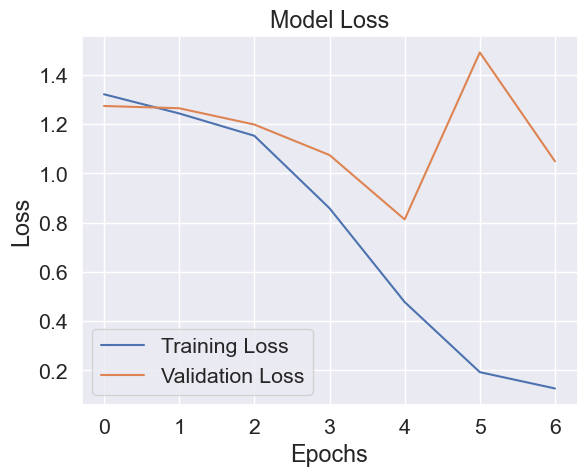

In [140]:
# Plotting the loss and accuracy curves
plt.figure(facecolor='white', edgecolor='black')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

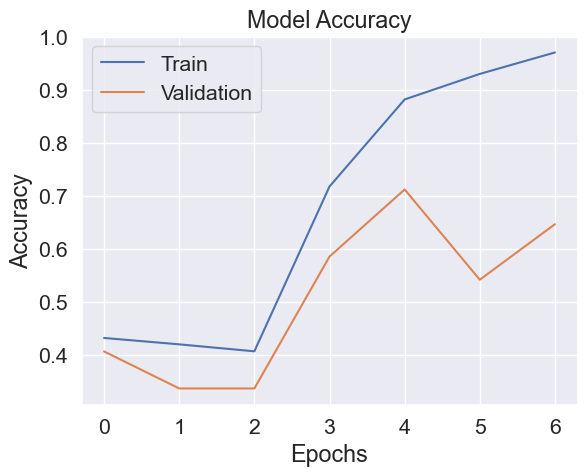

In [139]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

12/12 [==============================] - 4s 249ms/step


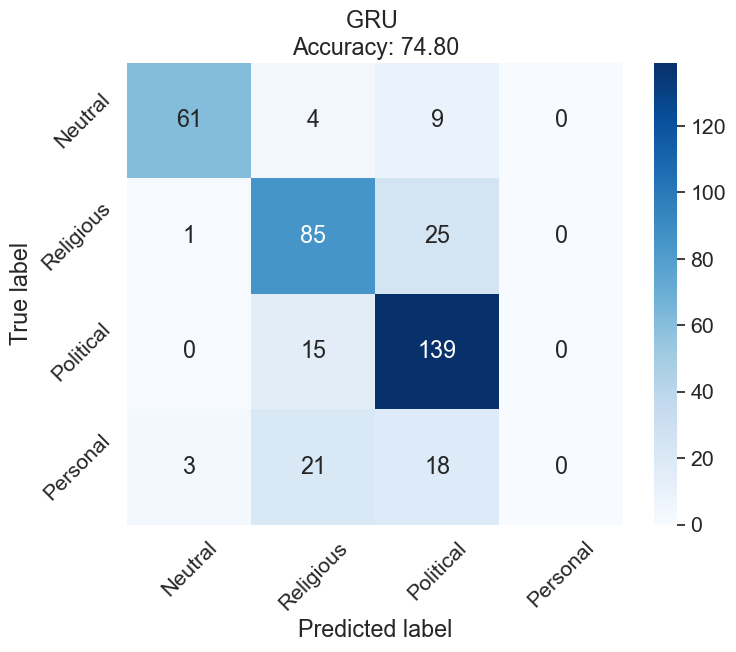

In [129]:
from sklearn.metrics import classification_report, confusion_matrix
# load the Saved model from directory
model = load_model("GRU_final_checkpoints.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(testing_label_seq, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Neutral' ,'Religious' ,'Political', 'Personal'], 
                     columns = ['Neutral' ,'Religious' ,'Political', 'Personal'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='g',cmap='Blues')
plt.title('GRU \nAccuracy: {0:.2f}'.format(accuracy_score(testing_label_seq, y_pred)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

In [130]:

report = pd.DataFrame(classification_report(y_true = testing_label_seq, y_pred = y_pred, output_dict=True)).transpose()
report = report.rename(index={'0': 'Neutral','1':'Personal','2':'Political','3':'Religious'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
Neutral,93.85,82.43,87.77,74.000000
Personal,68.00,76.58,72.03,111.000000
Political,72.77,90.26,80.58,154.000000
Religious,0.00,0.00,0.00,42.000000
accuracy,74.80,74.80,74.80,0.748031
macro avg,58.66,62.32,60.10,381.000000
weighted avg,67.45,74.80,70.60,381.000000
